In [ ]:
import os
import glob
import yaml
import cv2
import numpy as np
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import Dataset, DataLoader

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_classes = 3

model = torchvision.models.detection.fasterrcnn_resnet50_fpn()

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/Traffic_Light_Detection/models/fastercnn_relevance_epoch4.pt'))
model = model.eval().to(device)

### Фото

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, cities):
        self.imgs_path = '/content/drive/MyDrive/Traffic_Light_Detection/data_drive_u/'
        self.data = []
        self.cities = cities
        for city in self.cities:
            yml_path = self.imgs_path + 'DTLD_Labels/' + city + '_all.yml'
            with open(yml_path, 'r') as stream:
                yaml_file = yaml.safe_load(stream)
            for img_info in yaml_file:
                good_lights = 0
                for obj in img_info['objects']:
                    if str(obj['class_id'])[0] == '1' and obj['width'] > 0 and obj['height'] > 0:
                        good_lights += 1
                if good_lights > 0:
                    img_path = self.imgs_path + '/'.join(img_info['path'].split('/')[-4:])
                    self.data.append([img_path, img_info['objects']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, objects = self.data[idx]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (2048, 1024))
        img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2BGR)
        
        # Images are saved in 12 bit raw -> shift 4 bits
        img = np.right_shift(img, 4)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img /= 255.0

        target = {'boxes': [], 'labels': []}
        for obj in objects:
            obj['class_id'] = str(obj['class_id'])
            if obj['class_id'][0] == '1' and obj['width'] > 0 and obj['height'] > 0:
                target['boxes'].append([obj['x'], obj['y'], obj['x'] + obj['width'], obj['y'] + obj['height']])
                if int(obj['class_id'][4]) <= 2:
                    target['labels'].append(int(obj['class_id'][4]) + 1)
                else:
                    target['labels'].append(int(obj['class_id'][4]))
            
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)

        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float32)
        
        return img_tensor, target

In [ ]:
test_dataset = CustomDataset(['Bremen'])
def collate_fn(batch):
    return tuple(zip(*batch))
val_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
images, target = next(iter(val_loader))

In [ ]:
plt.imshow(images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


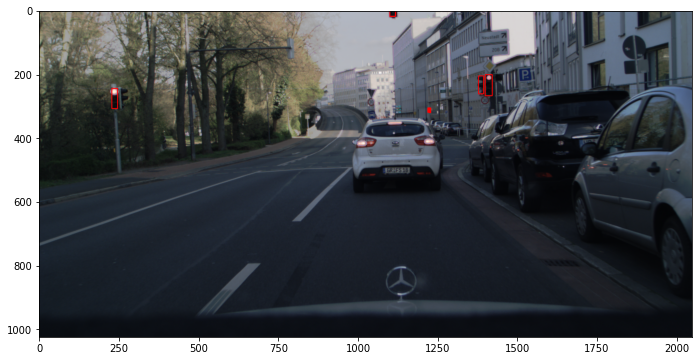

In [ ]:
image = images[0]
with torch.no_grad():
    outputs = model([image.permute(2, 0, 1).to(device)])
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    boxes = pred_bboxes[pred_scores >= 0.2].astype(np.int32)

image = np.array(image)
for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            (220, 0, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


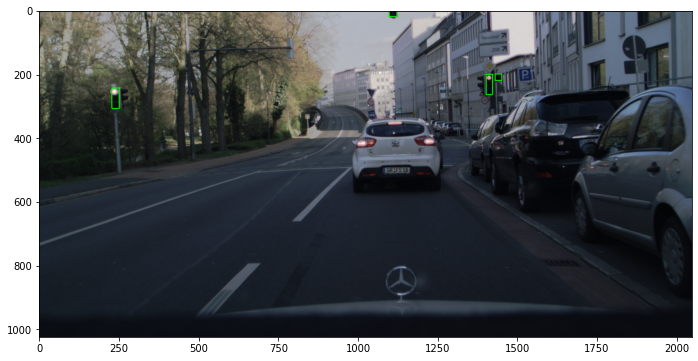

In [ ]:
image = images[0]

image = np.array(image)
for box in target[0]['boxes']:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            (0, 220, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(image)

### Видео

In [ ]:
video_path = '/content/drive/MyDrive/Traffic_Light_Detection/videos/video_0.mp4'

In [ ]:
cap = cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = f"{video_path.split('/')[-1].split('.')[0]}"

out = cv2.VideoWriter(f"/content/drive/MyDrive/Traffic_Light_Detection/video_outputs/{save_name}_relevance_0.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))

In [ ]:
frame_count = 0 
total_fps = 0 
model = model.eval().to(device)

In [ ]:
COLORS = {1: (0, 0, 1), 2: (1, 0, 0), 3: (1, 1, 0), 4: (0, 1, 0)}

In [ ]:
while(cap.isOpened()):
    
    ret, frame = cap.read()
    if ret == True:
        
        start_time = time.time()
        with torch.no_grad():
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32)
            frame /= 255
            frame_tensor = torch.as_tensor(frame.copy(), dtype=torch.float32)
            
            outputs = model([frame_tensor.permute(2, 0, 1).to(device)])
            pred_scores = outputs[0]['scores'].detach().cpu().numpy()
            pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
            pred_labels = outputs[0]['labels'].detach().cpu().numpy()
            boxes = pred_bboxes[pred_scores >= 0.2].astype(np.int32)
            labels = pred_labels[pred_labels >= 0.2].astype(np.int32)
        
        for i, box in enumerate(boxes):
            color = COLORS[labels[i]]
            cv2.rectangle(
                frame,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color, 2)
        
        end_time = time.time()
        fps = 1 / (end_time - start_time)
        total_fps += fps
        frame_count += 1
        
        wait_time = max(1, int(fps/4))
        frame = (frame * 255).astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        out.write(frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    else:
        break

In [ ]:
cap.release()

cv2.destroyAllWindows()

avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Average FPS: 7.511
